In [358]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import requests
import traceback

In [205]:
def create_start_time(row):
    date = row["Arrival"]
    if row.Starttime is None:
        return None
    
    return pd.Timestamp(date.year, date.month, date.day, int(row.Starttime[0:2]), int(row.Starttime[2:]))

def create_end_time(row):
    date = row["Arrival"]
    if row.Endtime is None:
        return None
    
    return pd.Timestamp(date.year, date.month, date.day, int(row.Endtime[0:2]), int(row.Endtime[2:]))

In [213]:
url = "https://s20aalt05web01.sky.blackbaud.com/2532Altru/ODataQuery.ashx?databasename=d32a1a5b-211a-4f58-bab1-36132004843f&AdHocQueryID=379fdd07-ded0-4a38-b183-7c0e49118619"

session = requests.Session()
session.auth = ('mrehnberg@adventuresci.org', '12sdf-sdfsd4-23sd')

r = session.get(url)

data = pd.DataFrame(r.json()['value'])
data["Arrival"] = pd.to_datetime(data["Arrival"])
data["Departure"] = pd.to_datetime(data["Departure"])

data["Start time"] = data.apply(create_start_time, axis=1)
data["End time"] = data.apply(create_end_time, axis=1)
data["Ticket type"] = data["Tickettype"]

data = data[["Name", "Arrival", "Departure", "Program", "Category", "Location", "Ticket type", "Quantity", "Capacity", "Start time", "End time"]]

In [344]:
def get_date(df, date):
    """Return the field trip entries for the given date."""
    
    if isinstance(date, str):
        split = date.split('-')
        date = datetime.datetime(int(split[0]),int(split[1]),int(split[2])).date()
        
    return df[df.Arrival.dt.date == pd.Timestamp(date)]

def get_location(df, location):
    """Return the field trip entries for the given location."""
    
    return df[df.Location == location]

def decimal_time(date):
    "Return the time as a decimal number of hours"
    
    return date.hour + date.minute/60

day = get_date(data, '2024-03-07')

/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df[df.Arrival.dt.date == pd.Timestamp(date)]


/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df[df.Arrival.dt.date == pd.Timestamp(date)]
/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df[df.Arrival.dt.date == pd.Timestamp(date)]
/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be c

/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df[df.Arrival.dt.date == pd.Timestamp(date)]
/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df[df.Arrival.dt.date == pd.Timestamp(date)]
/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be c

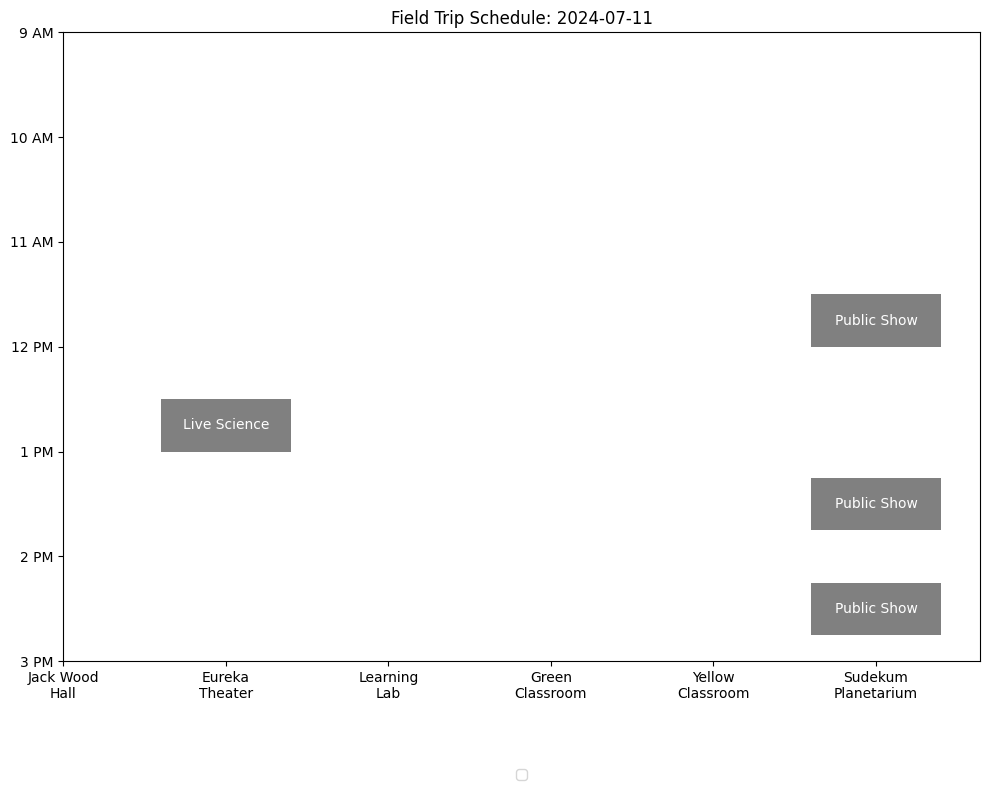

In [393]:
def format_name(name):
    """Format the name of a given program."""
    
    if name == 'SCH - L - Amusement Park Physics STEM Lab':
        return "Amusement\nPark Physics"
    if name == 'SCH - L - Squid Dissection STEM Lab':
        return "Squid\nDissection"
    if name == 'SCH - D - Matter Matters':
        return "Matter Matters"
    if name == 'PS - School Shows':
        return "School Show"
    if name == 'SCH - D - Cooking Up a Storm':
        return "Cooking Up\na Storm"
    if name == 'SCH - L - Cow Eye Dissection STEM Lab':
        return "Cow Eye\nDissection"
    if name == 'SCH - D - Get Energized!':
        return 'Get Energized!'
    if name == 'PS - To Worlds Beyond':
        return 'To Worlds\nBeyond'
    if name == 'SCH - L - Splitting Molecules STEM Lab':
        return 'Splitting\nMolecules'
    if name == 'SCH - D - Space Exploration':
        return 'Space\nExploration'
    if name == 'SCH - L - Fetal Pig STEM Lab':
        return 'Fetal Pig\nDissection'
    if name == 'PS - Nightwatch':
        return 'Nightwatch'
    if name == 'SCH - D - Chemistry is a Blast!':
        return 'Chemistry\nis a Blast'
    if name == "SCH - D - Shocking, It's Science!":
        return "Shocking,\nIt's Science!"
    if name == "SCH - D - Get Fired Up!":
        return 'Get Fired Up!'
    
    return name

def get_color(name):
    """Return a color for each unique school name"""
    
    if name not in name_colors:
         name_colors[name] = sb.color_palette("pastel", n_colors=10)[len(name_colors)]

    return name_colors[name]

def check_legend(name):
    """Check if the given name has been added to the legend."""
    
    if name in legend_names:
        return None
    
    legend_names[name] = True
    return name
    
locations = {
    "Jack Wood Hall": 1,
    "Eureka Theater": 2,
    "Learning Lab": 3,
    "Green Classroom": 4,
    "Yellow Classroom": 5,
    "Sudekum Planetarium": 6
}

for date in data.Arrival.dt.date.unique():
    day = get_date(data, date)

    if len(day) == 0:
        continue
        
    try:
        name_colors = {}
        legend_names = {}

        plt.clf()
        combo = day.groupby(["Name", "Program", "Location",  "Start time", "End time", "Capacity"]).sum(numeric_only=True).reset_index()

        for i, row in combo.iterrows():
            if row.Location is None:
                continue

            start = decimal_time(row["Start time"])
            end = decimal_time(row["End time"])
            duration = end - start
            plt.bar(locations[row.Location], duration, bottom=start, label=check_legend(row.Name), color=get_color(row.Name))
            plt.text(locations[row.Location], (start + end)/2, format_name(row.Program) + "\n("+str(row.Quantity)+"/" + str(row.Capacity)+ ")", ha='center', va='center', wrap=True)

        # Add public shows
        plt.bar(2, .5, bottom=12.5, color=(0.5, 0.5, 0.5))
        plt.text(2, 12.75, "Live Science", ha='center', va='center', wrap=True, color='white')

        plt.bar(6, .5, bottom=11.5, color=(0.5, 0.5, 0.5))
        plt.text(6, 11.75, "Public Show", ha='center', va='center', wrap=True, color='white')

        plt.bar(6, .5, bottom=13.25, color=(0.5, 0.5, 0.5))
        plt.text(6, 13.5, "Public Show", ha='center', va='center', wrap=True, color='white')

        plt.bar(6, .5, bottom=14.25, color=(0.5, 0.5, 0.5))
        plt.text(6, 14.5, "Public Show", ha='center', va='center', wrap=True, color='white')


        plt.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=2)

        plt.title("Field Trip Schedule: " + str(np.min(day.Arrival.dt.date)))
        plt.gca().invert_yaxis();
        plt.yticks([9, 10, 11, 12, 13, 14, 15], ["9 AM", "10 AM", "11 AM", "12 PM", "1 PM", "2 PM", "3 PM"]);
        plt.xticks([1, 2, 3, 4, 5, 6], ["Jack Wood\nHall", "Eureka\nTheater", "Learning\nLab", "Green\nClassroom", "Yellow\nClassroom", "Sudekum\nPlanetarium"]);

        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.tight_layout()
        plt.savefig('schedules/' + str(date) + '.pdf', dpi=300)
    except IndexError as e:
        print(e, date)
        pass

In [392]:
get_date(data, '2024-05-10')

/var/folders/44/c33mvrmx69b129zb2vqzqrkm0000gn/T/ipykernel_73188/2709485825.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df[df.Arrival.dt.date == pd.Timestamp(date)]


,Name,Arrival,Departure,Program,Category,Location,Ticket type,Quantity,Capacity,Start time,End time
377,Memphis STEAM Academy - Evans,2024-05-10 09:00:00,2024-05-10 12:00:00,Admission - TN Schools,Admission,None,Adult,15,0,NaT,NaT
378,Memphis STEAM Academy - Evans,2024-05-10 09:00:00,2024-05-10 12:00:00,Admission - TN Schools,Admission,None,School Student,43,0,NaT,NaT
379,Memphis STEAM Academy - Evans,2024-05-10 09:00:00,2024-05-10 12:00:00,Admission - TN Schools,Admission,None,Teacher,6,0,NaT,NaT
380,Memphis STEAM Academy - Evans,2024-05-10 09:00:00,2024-05-10 12:00:00,PS - School Shows,Planetarium Show,Sudekum Planetarium,Adult,15,160,2024-05-10 10:30:00,2024-05-10 11:00:00
381,Memphis STEAM Academy - Evans,2024-05-10 09:00:00,2024-05-10 12:00:00,PS - School Shows,Planetarium Show,Sudekum Planetarium,School Student,43,160,2024-05-10 10:30:00,2024-05-10 11:00:00
382,Memphis STEAM Academy - Evans,2024-05-10 09:00:00,2024-05-10 12:00:00,PS - School Shows,Planetarium Show,Sudekum Planetarium,Teacher,6,160,2024-05-10 10:30:00,2024-05-10 11:00:00
383,Tipton Christian Academy - Wilkerson,2024-05-10 09:00:00,2024-05-10 12:45:00,Admission - TN Schools,Admission,None,School Student,28,0,NaT,NaT
384,Tipton Christian Academy - Wilkerson,2024-05-10 09:00:00,2024-05-10 12:45:00,Admission - TN Schools,Admission,None,Teacher,3,0,NaT,NaT
385,Tipton Christian Academy - Wilkerson,2024-05-10 09:00:00,2024-05-10 12:45:00,SCH - L - Squid Dissection STEM Lab,School Program,Learning Lab,School Student,28,30,2024-05-10 11:40:00,2024-05-10 12:05:00
386,Joe Shafer Middle School - Lamberth,2024-05-10 09:00:00,2024-05-10 13:45:00,Admission - TN Schools,Admission,None,School Chaperone,15,0,NaT,NaT
